In [33]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
%matplotlib inline

from utils import read_results_from_files
plt.rcParams['figure.dpi'] = 200

In [62]:
results = dict()

# folder_name = 'hilbert_matrix/size=10000'
# folder_name = 'w8a/regcoef=1.00e-03'
# folder_name = 'a9a/regcoef=1.00e-03'
# folder_name = 'gisette/regcoef=1.00e-01'
# folder_name = 'covtype/regcoef=1.00e-03'
# folder_name = 'colon_cancer/regcoef=1.00e-01'
# folder_name = 'epsilon/regcoef=1.00e-04'
# folder_name = 'higgs/regcoef=1.00e-01'
folder_name = 'susy/regcoef=1.00e-01'


for line_search_method in ['wolfe']:
    folder = './results/{}'.format(folder_name)
    filenames = [
        '{}/rbfgs_svd-no-sigma_linesearch={}.pkl'\
            .format(folder, line_search_method), 
        '{}/rbfgs_gauss_linesearch={}.pkl'\
            .format(folder, line_search_method), 
        '{}/rbfgs_coord_linesearch={}.pkl'\
            .format(folder, line_search_method), 
        '{}/bfgs_linesearch={}.pkl'\
            .format(folder, line_search_method), 
        '{}/nesterov.pkl'.format(folder)
    ]
    results[line_search_method] = dict(zip(
        ['svd-no-sigma', 'gauss', 'coord', 'bfgs', 'nesterov'], 
        read_results_from_files(filenames)
    ))

with open('./logreg_solutions/{}'.format(folder_name), 'rb') as file:
    results['func_star'] = pickle.load(file)['func_star']

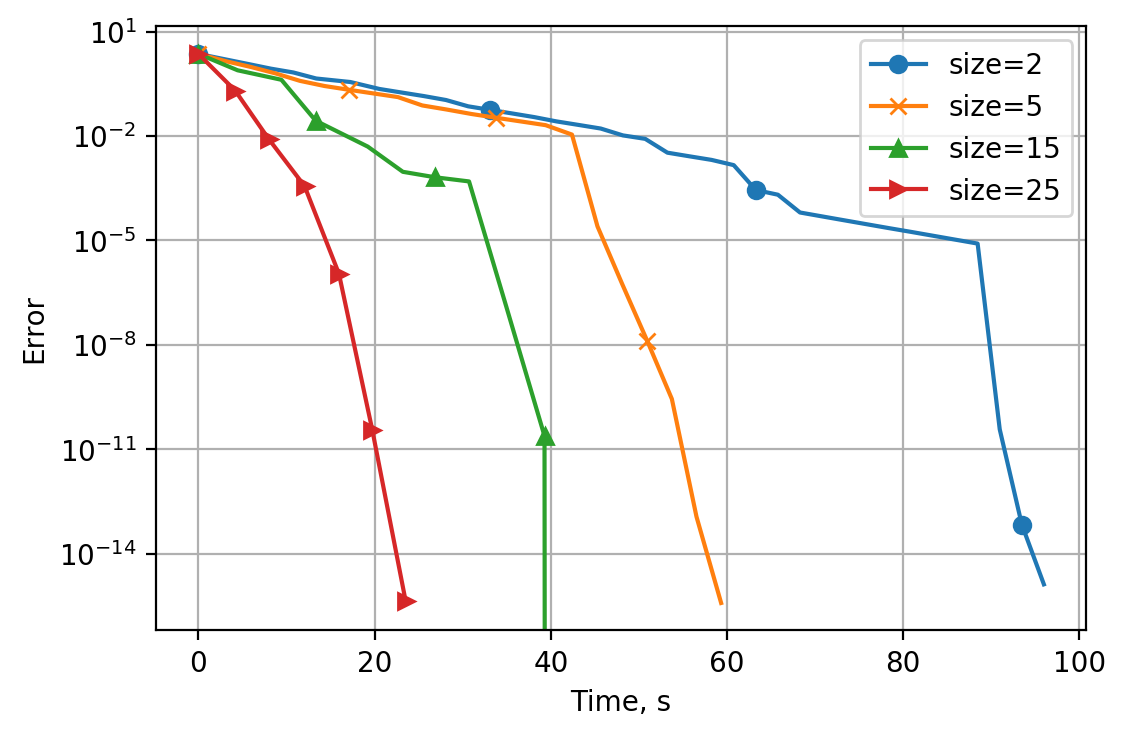

In [47]:
method_name = 'coord'
line_search_method = 'wolfe'
what_to_plot = 'func'
against = 'time'
markevery = 150
hist_len = 1000

lower_bound = np.float64(0) if what_to_plot == 'grad_norm' else results['func_star']

ax = plt.gca()
ax.set_yscale('log')

for sketch_size, marker in zip([2, 5, 15, 25], ['o', 'x', '^', '>', 'P', 's', '<', 'v', '.']):
    try:
        res = results[line_search_method][method_name][sketch_size]
    except KeyError:
        continue
    if against == 'scaled_iterations':
        xgrid = np.arange(0, sketch_size * len(res.hist[what_to_plot][:hist_len]), sketch_size)
    elif against == 'iterations':
        xgrid = range(len(res.hist[what_to_plot][:hist_len]))
    elif against == 'time':
        xgrid = res.hist['time'][:hist_len]
    to_plot = res.hist[what_to_plot][:hist_len] - lower_bound
    plt.plot(xgrid, to_plot, 
             label='size={}'.format(sketch_size), linestyle='-', marker=marker, 
             markevery=min(markevery, len(to_plot) - 2) // 3)

if against in ['iterations', 'scaled_iterations']:
    plt.xlabel('Iterations')
elif against == 'time':
    plt.xlabel('Time, s')

if what_to_plot == 'func':
    plt.ylabel('Error')
elif what_to_plot == 'grad_norm':
    plt.ylabel('Gradient norm')

plt.legend()
plt.grid()

# os.system('mkdir -p ./figures/{}'.format(folder_name))
# plt.savefig('./figures/{}/rbfgs_{}_linesearch={}'.format(folder_name, method_name, line_search_method))

In [63]:
best_sketch_sizes = {
    'gauss': 15, 
    'coord': 15, 
    'svd': 15, 
    'svd-no-sigma': 15
}

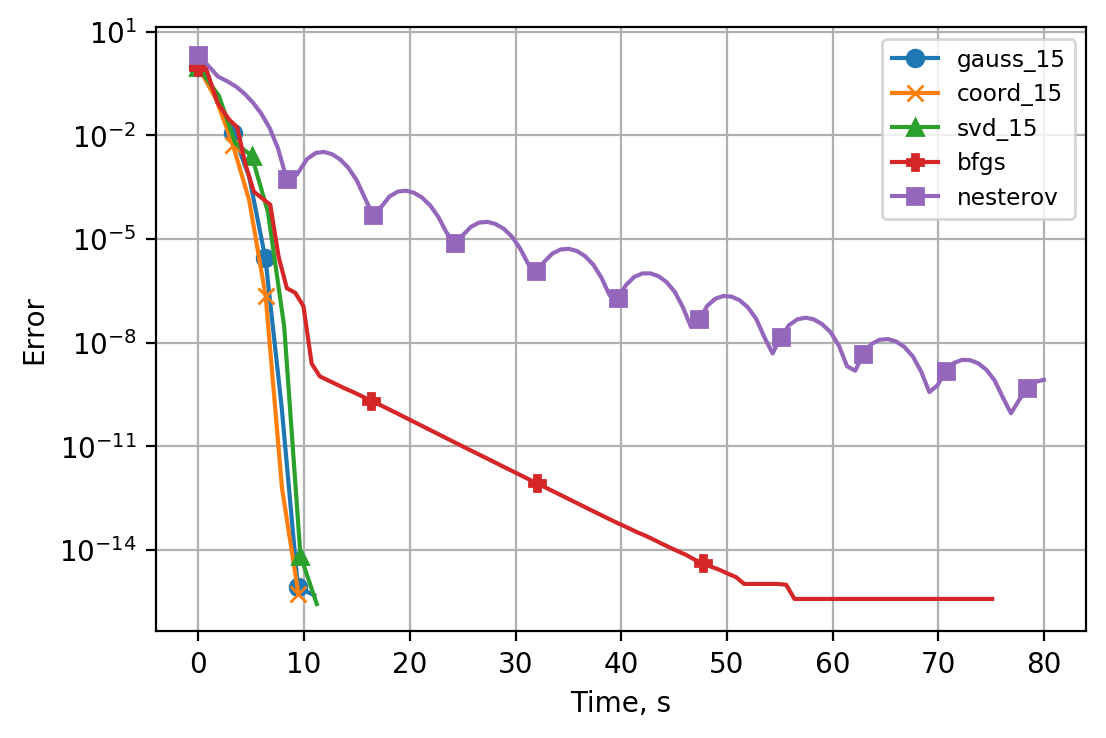

In [70]:
line_search_method = 'wolfe'
what_to_plot = 'func'
against = 'time'

hist_len_global = 500000
max_time = 80
markevery = 100

lower_bound = np.float64(0) if what_to_plot == 'grad_norm' else results['func_star']

ax = plt.gca()
ax.set_yscale('log')

for method_name, marker, markevery in zip(#['nesterov'], 
                                          ['gauss', 'coord', 'svd-no-sigma', 'bfgs', 'nesterov'], 
                                          ['o', 'x', '^', 'P', 's', '<', '>', 'v', '.'], 
                                          [2, 3, 7, 20, 10]):
    
    sketch_size = best_sketch_sizes.get(method_name, None)
    try:
        res = results[line_search_method][method_name]
    except KeyError:
        continue
    label = method_name
    if method_name == 'svd-no-sigma':
        label = 'svd'
    if method_name in ['gauss', 'coord', 'svd', 'svd-no-sigma']:
        res = res[sketch_size]
        label += '_{}'.format(sketch_size)
    time_len = (res.hist['time'] < np.array(max_time)).sum()
    hist_len = min(hist_len_global, time_len)
    
    if against == 'iterations':
        xgrid = range(len(res.hist[what_to_plot][:hist_len]))
    elif against == 'time':
        xgrid = res.hist['time'][:hist_len]

    plot_every = 1 if method_name == 'nesterov' else 1
    to_plot = res.hist[what_to_plot][:hist_len] - lower_bound
    plt.plot(xgrid[::plot_every], to_plot[::plot_every], label=label, linestyle='-', marker=marker, 
             markevery=min(markevery, len(to_plot) // 2 - 1))

if against == 'iterations':
    plt.xlabel('Iterations')
elif against == 'time':
    plt.xlabel('Time, s')
if what_to_plot == 'func':
    plt.ylabel('Error')
else:
    plt.ylabel('Gradient norm')
plt.legend(loc='upper right', fontsize='small')
plt.grid()

# os.system('mkdir -p ./figures/{}'.format(folder_name))
# plt.savefig('./figures/{}/comparison'.format(folder_name, method_name, line_search_method))